## `Import Libraries`

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib, os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score
import tensorflow as tf

## `Get the Dataset`

In [8]:
# read dataset
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df = pd.read_csv(url)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## `EDA`

In [9]:
# rename columns
df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')
df.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [10]:
# info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [11]:
# stats
df.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [12]:
# check NaNs
df.isna().sum().sort_values(ascending=False)

cabin          687
age            177
embarked         2
passengerid      0
name             0
pclass           0
survived         0
sex              0
parch            0
sibsp            0
fare             0
ticket           0
dtype: int64

In [13]:
# Columns that has NaNs
df.columns[df.isna().any()].tolist()

['age', 'cabin', 'embarked']

## `Visualization`

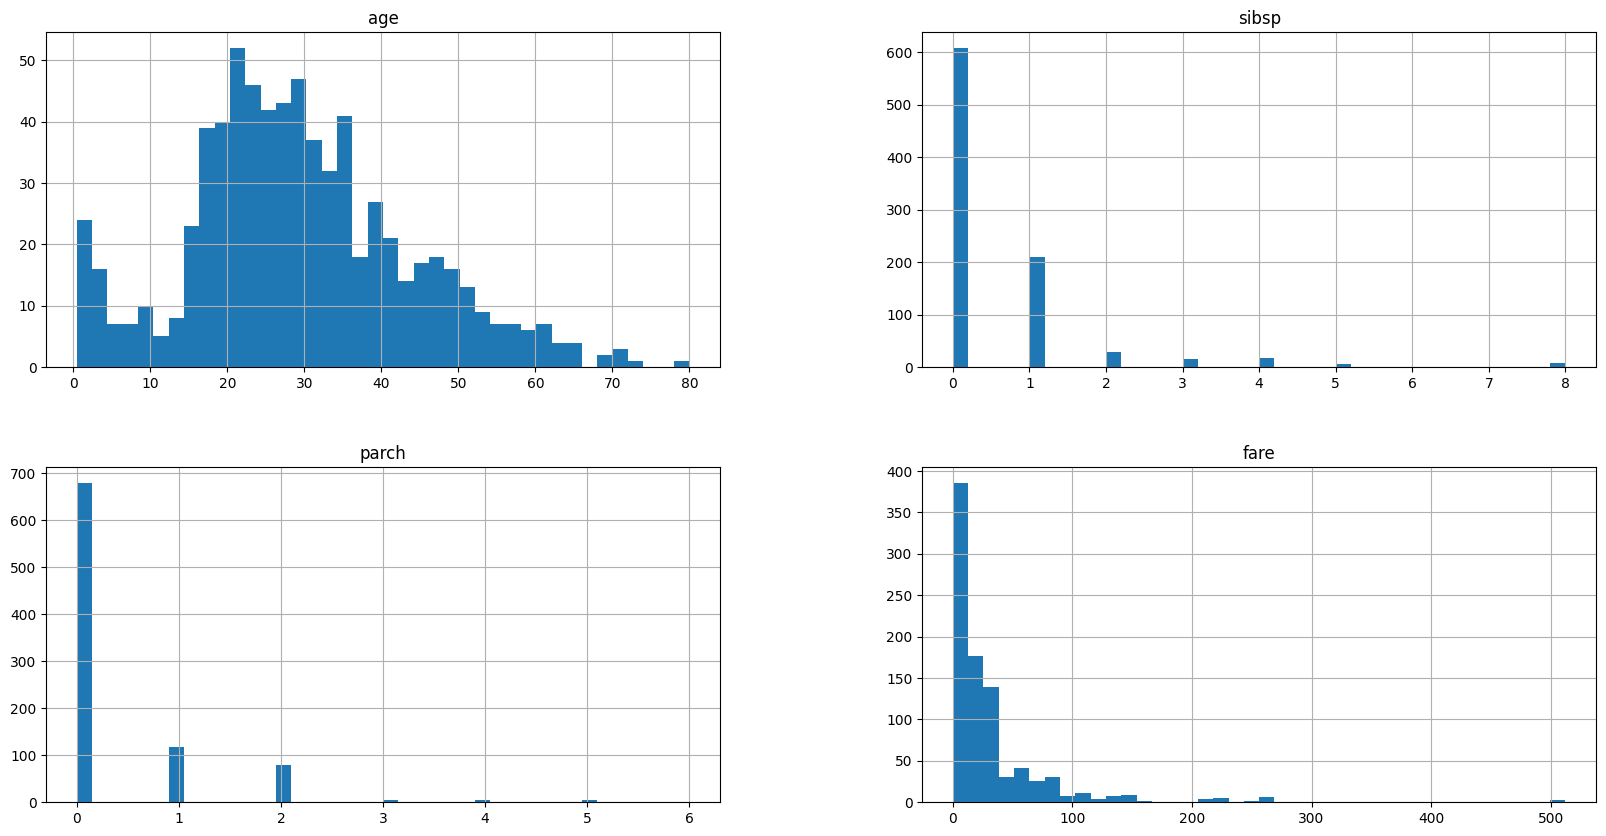

In [14]:
# Numerical cols
num_cols = ['age', 'sibsp', 'parch', 'fare']
df[num_cols].hist(figsize=(20, 10), bins=40)
plt.show()

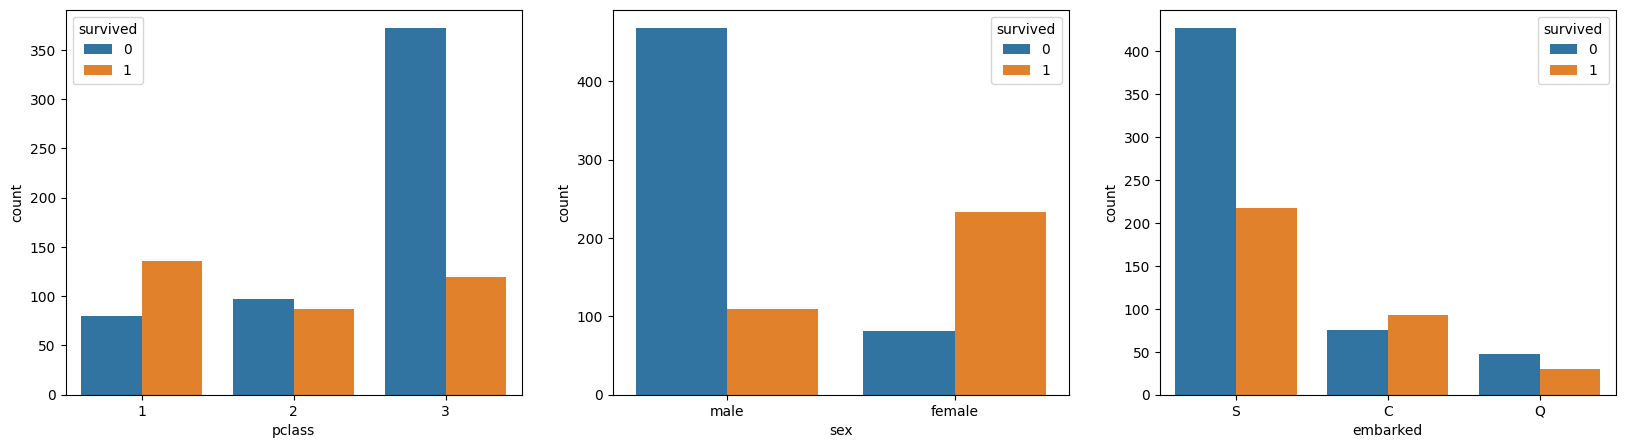

In [15]:
# Categorical cols
# Let's work on these cols
categ_cols = ['pclass', 'sex', 'embarked']
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for i, col in enumerate(categ_cols):
    sns.countplot(data=df, x=col, ax=axes[i], hue="survived")
plt.show()

## `Feature Engineering`

In [16]:
# Add 1 to add the passenger himself
df['family_size'] = df['sibsp'] + df['parch'] + 1

# Make another column if he is alone or not
def is_alone(x):
    if x > 1:
        return 0
    else:
        return 1
# apply
df['is_alone'] = df['family_size'].apply(is_alone)

In [17]:
# Check now
df[['sibsp', 'parch', 'family_size', 'is_alone']].head()

,sibsp,parch,family_size,is_alone
0,1,0,2,0
1,1,0,2,0
2,0,0,1,1
3,1,0,2,0
4,0,0,1,1


## `Split Dataset`

In [18]:
# to X & y
choosen_features = ["pclass", "sex", "age", "sibsp", "parch", "family_size", "is_alone", "fare", "embarked"]
X = df[choosen_features]
y = df['survived']

# to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42, stratify=y)

In [19]:
# Check shapes
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print()
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (712, 9)
y_train shape (712,)

X_test shape (179, 9)
y_test shape (179,)


## `Preporcessing`

In [20]:
# divide into subsets
num_cols = ["age", "fare"]
categ_cols = ["sex", "embarked"]
ready_cols = list(set(X_train.columns) - set(num_cols) - set(categ_cols))

# check
print("Numerical cols: ", num_cols)
print("Categorical cols: ", categ_cols)
print("Ready cols: ", ready_cols)

Numerical cols:  ['age', 'fare']
Categorical cols:  ['sex', 'embarked']
Ready cols:  ['sibsp', 'parch', 'is_alone', 'pclass', 'family_size']


In [21]:
# Numerical pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
categ_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, drop="first", handle_unknown="ignore"))
])

# Ready pipeline
ready_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Combine all
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('categ', categ_pipeline, categ_cols),
    ('ready', ready_pipeline, ready_cols)
])

# Apply
X_train_final = preprocessor.fit_transform(X_train)
X_test_final = preprocessor.transform(X_test)

In [22]:
# Check shapes again
print("X_train_final shape", X_train_final.shape)
print("y_train shape", y_train.shape)
print()
print("X_test_final shape", X_test_final.shape)
print("y_test shape", y_test.shape)

X_train_final shape (712, 10)
y_train shape (712,)

X_test_final shape (179, 10)
y_test shape (179,)


In [23]:
# Artifcats folder
ARTIFACTS_FOLDER_PATH = os.path.join(os.getcwd(), "artifacts")
os.makedirs(ARTIFACTS_FOLDER_PATH, exist_ok=True)

In [18]:
# Dump pipeline
joblib.dump(preprocessor, os.path.join(ARTIFACTS_FOLDER_PATH, "preprocessor.joblib"))

['/content/artifacts/preprocessor.joblib']

-----

## `Basic NN Model`

In [19]:
tf.random.set_seed(45)

In [20]:
# build a simple NN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=128, activation="relu", input_shape=(X_train_final.shape[1],)),
    tf.keras.layers.Dense(units=64, activation="relu"),
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.Dense(units=16, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=['accuracy'])

# Fitting
history = model.fit(X_train_final, y_train,
          validation_split=0.2,
          epochs=100,
          batch_size=32)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.6589 - loss: 0.6473 - val_accuracy: 0.6364 - val_loss: 0.6012
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6495 - loss: 0.6045 - val_accuracy: 0.7483 - val_loss: 0.5536
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6931 - loss: 0.5676 - val_accuracy: 0.7552 - val_loss: 0.5033
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7333 - loss: 0.5311 - val_accuracy: 0.8042 - val_loss: 0.4757
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7748 - loss: 0.5103 - val_accuracy: 0.8182 - val_loss: 0.4597
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7905 - loss: 0.4955 - val_accuracy: 0.8112 - val_loss: 0.4469
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8034 - loss: 0.4754 - val_accuracy: 0.8182 - val_loss: 0.4419
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8134 - loss: 0.4570 - val_accuracy: 0.8112 -

In [22]:
# Evaluate on test
test_loss, test_acc = model.evaluate(X_test_final, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} %")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7945 - loss: 0.7001
Test Loss: 0.7007
Test Accuracy: 0.7933 %


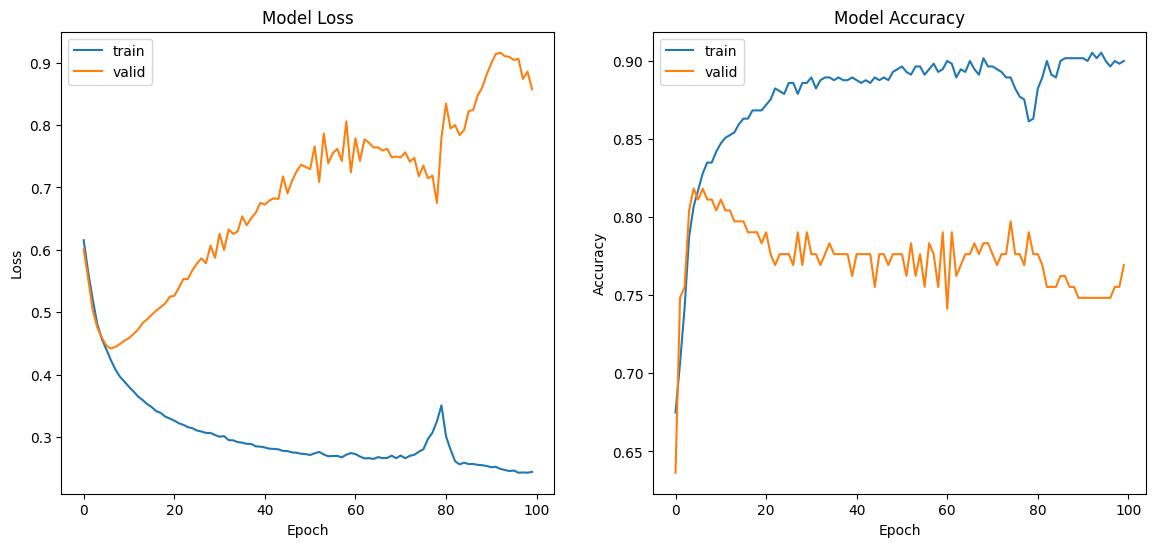

In [23]:
# Visulalize history
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plt.sca(ax[0])
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.sca(ax[1])
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## `Enhancing Model`

In [24]:
# build a simple NN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=128, activation="relu", input_shape=(X_train_final.shape[1],)),
    tf.keras.layers.Dropout(0.5, seed=97),
    tf.keras.layers.Dense(units=64, activation="relu"),
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.Dropout(0.5, seed=97),
    tf.keras.layers.Dense(units=16, activation="relu"),
    tf.keras.layers.Dropout(0.5, seed=97),
    tf.keras.layers.Dense(units=1, activation="sigmoid"),
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 128)                 │           1,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=['accuracy'])

# Fitting
history = model.fit(X_train_final, y_train,
          validation_split=0.2,
          epochs=100,
          batch_size=32)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.5555 - loss: 0.6908 - val_accuracy: 0.5944 - val_loss: 0.6532
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5750 - loss: 0.6693 - val_accuracy: 0.6014 - val_loss: 0.6407
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5518 - loss: 0.6813 - val_accuracy: 0.6084 - val_loss: 0.6307
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6007 - loss: 0.6492 - val_accuracy: 0.6503 - val_loss: 0.6199
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5884 - loss: 0.6659 - val_accuracy: 0.6434 - val_loss: 0.6127
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5921 - loss: 0.6583 - val_accuracy: 0.6643 - val_loss: 0.6003
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6285 - loss: 0.6487 - val_accuracy: 0.7273 - val_loss: 0.5949
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6529 - loss: 0.6369 - val_accuracy: 0.7483 -

In [26]:
# Evaluate on test
test_loss, test_acc = model.evaluate(X_test_final, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} %")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7960 - loss: 0.4609
Test Loss: 0.4641
Test Accuracy: 0.8101 %


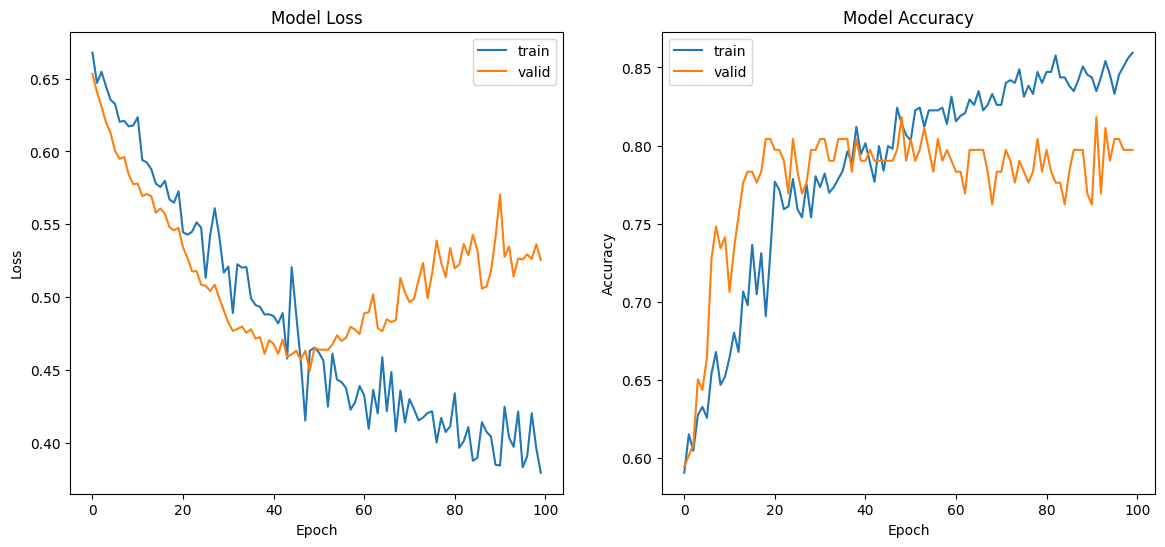

In [27]:
# Visulalize history
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plt.sca(ax[0])
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.sca(ax[1])
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## `Enhancing the Model`

In [28]:
# Try add a reguralizer l2
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.01), input_shape=(X_train_final.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer="l2"),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer="l2"),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 128)                 │           1,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Early Stopping
early_stopp = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)

# Fit
histroy = model.fit(X_train_final, y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stopp])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - accuracy: 0.5508 - loss: 2.2727 - val_accuracy: 0.6014 - val_loss: 2.0002
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6015 - loss: 1.9347 - val_accuracy: 0.6573 - val_loss: 1.7106
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6553 - loss: 1.6632 - val_accuracy: 0.6783 - val_loss: 1.4852
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6734 - loss: 1.4596 - val_accuracy: 0.7343 - val_loss: 1.2975
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7090 - loss: 1.2885 - val_accuracy: 0.7552 - val_loss: 1.1511
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7342 - loss: 1.1558 - val_accuracy: 0.7552 - val_loss: 1.0434
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7407 - loss: 1.0588 - val_accuracy: 0.7902 - val_loss: 0.9510
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7593 - loss: 0.9763 - val_accuracy: 0.8112 -

In [33]:
# Evaluate on test
test_loss, test_acc = model.evaluate(X_test_final, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} %")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7690 - loss: 0.5474 
Test Loss: 0.5279
Test Accuracy: 0.7989 %


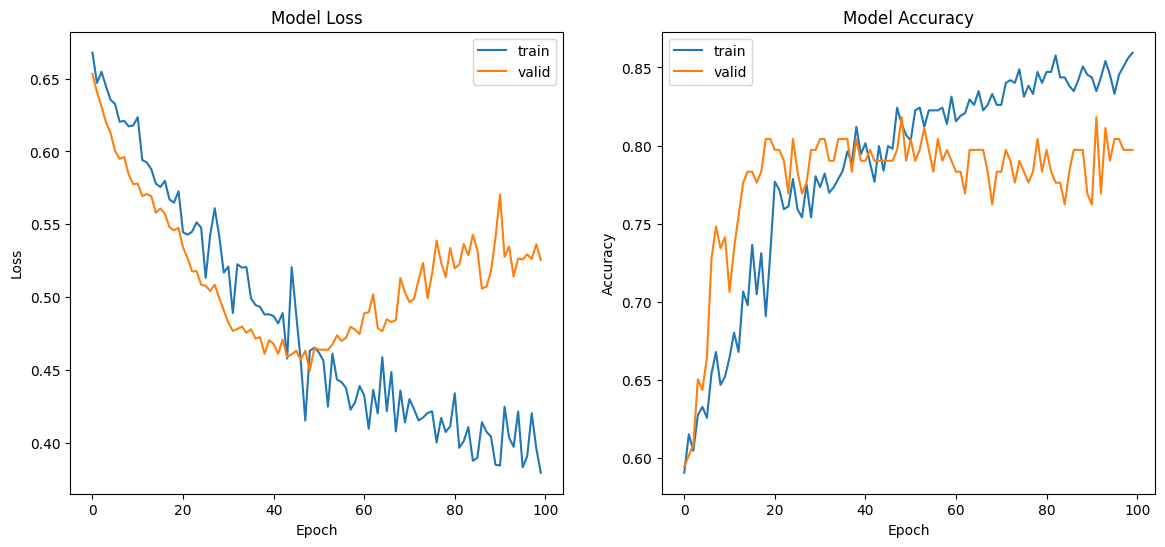

In [31]:
# Visulalize history
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plt.sca(ax[0])
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.sca(ax[1])
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## `Using Keras-Tuner`

In [24]:
!pip install -q keras-tuner

In [35]:
from kerastuner import RandomSearch

In [36]:
def build_model(hp):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Input(shape=(X_train_final.shape[1],)),

      # First Layer
      tf.keras.layers.Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32),
                            activation="relu"),
      # Dropout
      tf.keras.layers.Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)),

      # Second Layer
      tf.keras.layers.Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32),
                            activation="relu"),
      # Dropout
      tf.keras.layers.Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)),

      # Ouptut layer
      tf.keras.layers.Dense(1, activation="sigmoid")
  ])

  # compile model
  model.compile(
      loss="binary_crossentropy",
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      metrics=['accuracy']
  )

  return model

In [37]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

In [38]:
tuner = RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=2,
    directory="hyperparameter_tuning",
    project_name="titanic_project",
    seed=174
)

In [39]:
# Running tuner
tuner.search(X_train_final, y_train,
             epochs=50,
             validation_split=0.2,
             callbacks=[early_stopping],
             )

Trial 10 Complete [00h 00m 17s]
val_accuracy: 0.8321678042411804

Best val_accuracy So Far: 0.839160829782486
Total elapsed time: 00h 03m 25s


In [41]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


<Sequential name=sequential, built=True>

In [42]:
# Evaluate on test
test_loss, test_acc = best_model.evaluate(X_test_final, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} %")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8022 - loss: 0.4608
Test Loss: 0.4458
Test Accuracy: 0.8156 %


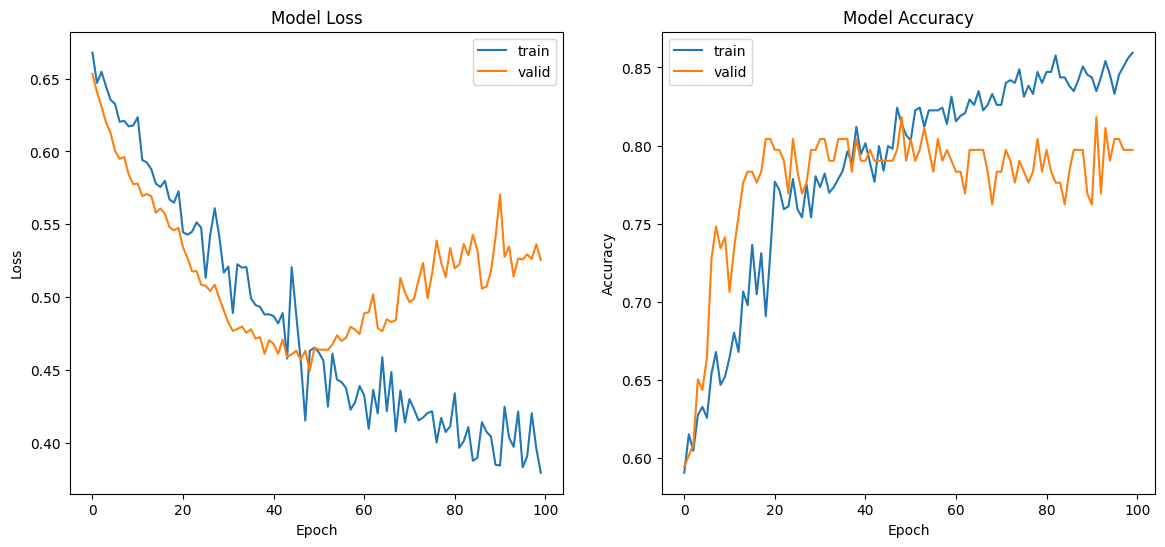

In [43]:
# Visulalize history
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plt.sca(ax[0])
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.sca(ax[1])
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

----

### `Save & Load the Best Model`

In [44]:
# Save the model locally
best_model.save(os.path.join(ARTIFACTS_FOLDER_PATH, "best_model.keras"))

In [45]:
# Load pretrained model
model = tf.keras.models.load_model(os.path.join(ARTIFACTS_FOLDER_PATH, "best_model.keras"))

# Evaluate on test
test_loss, test_acc = best_model.evaluate(X_test_final, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} %")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8022 - loss: 0.4608 
Test Loss: 0.4458
Test Accuracy: 0.8156 %


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### `Inference`

In [51]:
# Imagine that these are some samples
samples = df.sample(10, random_state=14)

# Processing
samples_processed = preprocessor.transform(samples)

# Predict
predictions = (model.predict(samples_processed) > 0.5).astype("int32")

predictions.flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1], dtype=int32)

In [53]:
results = pd.DataFrame({
    'Passenger_ID': samples["passengerid"],
    'Predicted': ['Survived' if pred == 1 else 'Not Survived' for pred in predictions.flatten()],
})

results

,Passenger_ID,Predicted
75,76,Not Survived
602,603,Not Survived
119,120,Not Survived
647,648,Not Survived
115,116,Not Survived
472,473,Survived
547,548,Not Survived
735,736,Not Survived
467,468,Not Survived
759,760,Survived


-----